In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define the model - will be used the test the performance of our attack

In [2]:
import torch
import pytorch_lightning as pl
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

class CIFAR10Model(pl.LightningModule):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.resnet = models.resnet18(pretrained=False, num_classes=10)
        self.accuracy = Accuracy(task='multiclass', num_classes=10)
        self.save_hyperparameters(logger=False)
       
        
    def forward(self, x):
        out = self.resnet(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = F.cross_entropy(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', self.accuracy(preds, y), on_step=True, on_epoch=True, prog_bar=True)
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def prepare_data(self):
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        self.testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

    def test_dataloader(self):
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        testloader = DataLoader(self.testset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
        return testloader


Model Training

In [3]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=2)

model_checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")



# Train the model
model = CIFAR10Model()

trainer = pl.Trainer(gpus=-1, max_epochs=10, callbacks=[early_stop_callback, model_checkpoint_callback])
trainer.fit(model)

# Load the best saved model checkpoint from the callback
checkpoint_path = model_checkpoint_callback.best_model_path
model = CIFAR10Model.load_from_checkpoint(checkpoint_path)

# Test the model
trainer = pl.Trainer(gpus=-1)
trainer.test(model)
              
# Print the test results
test_results = trainer.callback_metrics
test_loss = test_results['test_loss'].item()
test_acc = test_results['test_acc'].item()
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utili

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 11.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 391: 'val_loss' reached 1.37266 (best 1.37266), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 782: 'val_loss' reached 1.05027 (best 1.05027), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1173: 'val_loss' reached 1.01015 (best 1.01015), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1564: 'val_loss' reached 0.84301 (best 0.84301), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1955: 'val_loss' reached 0.80203 (best 0.80203), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2346: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2737: 'val_loss' reached 0.71606 (best 0.71606), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3128: 'val_loss' reached 0.70488 (best 0.70488), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3519: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3910: 'val_loss' reached 0.66879 (best 0.66879), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Plea

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.7714999914169312
     test_loss_epoch        0.6687856316566467
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Loss: 0.6688, Test Acc: 0.7715


Accuracy on test set (before any attack)

In [4]:
# Load the trained model
model = CIFAR10Model.load_from_checkpoint('checkpoints/best-checkpoint.ckpt')

# Test the model
trainer = pl.Trainer(gpus=-1)
trainer.test(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.7713000178337097
     test_loss_epoch        0.6546797752380371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.6546797752380371, 'test_acc_epoch': 0.7713000178337097}]

Re import testset

In [5]:
import torchvision
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified


Our attack code - solving an optimization problem defined in Cralini-Wagner paper Towards Evaluating the Robustness of Neural Networks
https://arxiv.org/abs/1608.04644

In [6]:
"""The CarliniWagnerL2 attack."""
import torch
from typing import Union

INF = float("inf")

def map_to_tanh_space(x, clip_min, clip_max, torch):
        # Map images into the tanh-space
        x = (x - clip_min) / (clip_max - clip_min)
        x = torch.clamp(x, 0, 1)
        x = x * 2 - 1
        x = torch.arctanh(x * 0.999999)
        return x

def get_loss_func(confidence, torch):
    return lambda real, other, targeted: torch.max(
        ((other - real) if targeted else (real - other)) + confidence,
        torch.tensor(0.0).to(real.device),
    )

def get_l2_func(torch):
    return lambda x, y: torch.pow(x - y, 2).sum(list(range(len(x.size())))[1:])

def get_optimizer_func(modifier, lr, torch):
    return torch.optim.Adam([modifier], lr=lr)

def update_best_results(true_labels, l2_distances, logits, adversarial_examples, orig_best_l2, orig_best_predictions, orig_best_attacks, curr_best_l2, curr_best_predictions, attack_success_func):
    # Update best results for each example in the batch
    for n, (l2_n, logits_n, adversarial_example_n) in enumerate(zip(l2_distances, logits, adversarial_examples)):
        # Get the true label for this example
        true_label_n = true_labels[n]
        # Check if the attack was successful using the provided attack_success_func
        succeeded = attack_success_func(logits_n, true_label_n, is_logits=True)
        if l2_n < orig_best_l2[n] and succeeded:
            # If this adversarial example has a lower L2 distance than the current best for this example, and the attack was successful:
            pred_n = torch.argmax(logits_n)
            # Update the original best results for this example
            orig_best_l2[n] = l2_n
            orig_best_predictions[n] = pred_n
            orig_best_attacks[n] = adversarial_example_n
            # Since l2_n < orig_best_l2[n], we know that l2_n is also less than curr_best_l2[n], so we update that too
            curr_best_l2[n] = l2_n
            curr_best_predictions[n] = pred_n
        elif l2_n < curr_best_l2[n] and succeeded:
            # If this adversarial example has a lower L2 distance than the current best for this example, but not lower than the original best:
            curr_best_l2[n] = l2_n
            curr_best_predictions[n] = torch.argmax(logits_n)

def binary_search_step(x, y, bestscore, lower_bound, upper_bound, const_value, is_attack_successful):
    # Binary search step
    for n in range(len(x)):
        y_n = y[n]

        if not is_attack_successful(bestscore[n], y_n) or bestscore[n] == -1:
            # Failure, either multiply by 10 if no solution found yet
            # or do binary search with the known upper bound
            lower_bound[n] = max(lower_bound[n], const_value[n])
            if upper_bound[n] < 1e9:
                const_value[n] = (lower_bound[n] + upper_bound[n]) / 2
            else:
                const_value[n] *= 10
        else:
            # Success, divide const_value by two
            upper_bound[n] = min(upper_bound[n], const_value[n])
            if upper_bound[n] < 1e9:
                const_value[n] = (lower_bound[n] + upper_bound[n]) / 2


def carlini_wagner_l2(
    model_fn,
    x,
    n_classes,
    y=None,
    targeted=False,
    lr=5e-3,
    confidence=0,
    clip_min=0,
    clip_max=1,
    initial_const=1e-2,
    binary_search_steps=5,
    max_iterations=1000,
):
    """
    Performs the Carlini-Wagner L2 attack, originally proposed by Carlini and Wagner. This iterative attack finds adversarial examples on many defenses that are robust to other attacks. 

    Paper link: https://arxiv.org/abs/1608.04644

    This attack uses Adam and a specially-chosen loss function to find adversarial examples with lower distortion than other attacks. However, it is often slower than other attacks.

    Args:
      - model_fn: A callable that takes an input tensor and returns the model logits. The logits should be a tensor of shape (n_examples, n_classes).
      - x: Input tensor of shape (n_examples, ...), where ... can be any arbitrary dimension that is compatible with model_fn.
      - n_classes: The number of classes.
      - y: (Optional) Tensor with true labels. If targeted is True, then provide the target label. Otherwise, only provide this parameter if you'd like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect (explained in this paper: https://arxiv.org/abs/1611.01236). If provide y, it should be a 1D tensor of shape (n_examples, ). Default is None.
      - targeted: (Optional) Boolean. Is the attack targeted or untargeted? Untargeted, the default, will try to make the label incorrect. Targeted will instead try to move in the direction of being more like y.
      - lr: (Optional) Float. The learning rate for the attack algorithm. Default is 5e-3.
      - confidence: (Optional) Float. Confidence of adversarial examples: higher produces examples with larger L2 distortion, but more strongly classified as adversarial. Default is 0.
      - clip_min: (Optional) Float. Minimum float value for adversarial example components. Default is 0.
      - clip_max: (Optional) Float. Maximum float value for adversarial example components. Default is 1.
      - initial_const: The initial tradeoff-constant to use to tune the relative importance of size of the perturbation and confidence of classification. If binary_search_steps is large, the initial constant is not important. A smaller value of this constant gives lower distortion results. Default is 1e-2.
      - binary_search_steps: (Optional) Int. The number of times we perform binary search to find the optimal tradeoff-constant between norm of the perturbation and confidence of the classification. Default is 5.
      - max_iterations: (Optional) Int. The maximum number of iterations. Setting this to a larger value will produce lower distortion results. Using only a few iterations requires a larger learning rate, and will produce larger distortion results. Default is 1000.

    Returns:
      An adversarial tensor with the same shape as x.
    """
    

    def is_attack_successful(pred: Union[torch.Tensor, int], label: int, is_logits: bool = False) -> bool:
        """
        Helper function to compare the prediction against a label.

        Args:
            pred: The predicted class as an integer or a 1D tensor of logits.
            label: The label to compare against as an integer.
            is_logits: Whether the input prediction is a 1D tensor of logits.
                      Default is False.

        Returns:
            A boolean indicating if the prediction matches the label for untargeted attack or
            if the prediction is different from the label for targeted attack.
        """

        # Convert logits to predicted class if necessary
        if is_logits:
            pred_copy = pred.clone().detach()
            pred_copy[label] += -confidence if targeted else confidence
            pred = torch.argmax(pred_copy)

        return pred == label if targeted else pred != label

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        pred = model_fn(x)
        y = torch.argmax(pred, 1)

    # Initialize some values needed for binary search on const
    lower_bound = [0.0] * len(x)
    upper_bound = [1e10] * len(x)
    const_value = x.new_ones(len(x), 1) * initial_const

    o_bestl2 = [INF] * len(x)
    o_bestscore = [-1.0] * len(x)
    x = torch.clamp(x, clip_min, clip_max)
    ox = x.clone().detach()  # save the original x
    o_bestattack = x.clone().detach()

    # Map images into the tanh-space
    x = map_to_tanh_space(x, clip_min, clip_max, torch)

    # Prepare some variables
    modifier = torch.zeros_like(x, requires_grad=True)
    y_onehot = torch.nn.functional.one_hot(y.long(), n_classes).to(torch.float)

    # Define loss functions and optimizer
    f_fn = get_loss_func(confidence, torch)
    l2dist_fn = get_l2_func(torch)
    optimizer = get_optimizer_func(modifier, lr, torch)

    # Outer loop performing binary search on const
    for outer_step in range(binary_search_steps):
        # Initialize some values needed for the inner loop
        bestl2 = [INF] * len(x)
        bestscore = [-1.0] * len(x)

        # Inner loop performing attack iterations
        for i in range(max_iterations):
            # One attack step
            new_x = (torch.tanh(modifier + x) + 1) / 2
            new_x = new_x * (clip_max - clip_min) + clip_min
            logits = model_fn(new_x)

            real = torch.sum(y_onehot * logits, 1)
            other, _ = torch.max((1 - y_onehot) * logits - y_onehot * 1e4, 1)

            optimizer.zero_grad()
            f = f_fn(real, other, targeted)
            l2 = l2dist_fn(new_x, ox)
            loss = (const_value * f + l2).sum()
            loss.backward()
            optimizer.step()

            # Updating the best results at the end of the step
            update_best_results(y, l2, logits, new_x, o_bestl2, o_bestscore, o_bestattack, bestl2, bestscore, is_attack_successful)

        #perform a Binary search step
        binary_search_step(x, y, bestscore, lower_bound, upper_bound, const_value, is_attack_successful)
                 

    return o_bestattack.detach()

Testing code for accuracy

In [7]:
# Define a function to evaluate the accuracy of the model on the test dataset
def test(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            outputs = model(images)
            images = images.detach()
            _, predicted = torch.max(outputs.cpu().data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))

In [8]:
MAX_ITERATIONS = 10

Use the attack function - only on first batch for fast runtime

In [9]:
def attack_params(x, y):
  # Define the attack parameters
  attack_params_ = {
      'model_fn': model,
      'x': x,
      'n_classes': 10,
      'y': y,
      'targeted': False,
      'lr': 0.01,
      'confidence': 0,
      'clip_min': 0,
      'clip_max': 1,
      'initial_const': 0.01,
      'binary_search_steps': 5,
      'max_iterations': MAX_ITERATIONS
  }
  return attack_params_

# Generate the adversarial examples using the Carlini-Wagner L2 attack
adv_examples = []
regular_examples = []
for data in testloader:
    images, labels = data
    params = attack_params(images, labels)
    adv_images = carlini_wagner_l2(**params)

    adv_examples.append((adv_images, labels))
    regular_examples.append((images, labels))
    break

# # Convert the adversarial examples to PyTorch tensors
# adv_examples = torch.from_numpy(adv_examples).float()


In [10]:
# # Set the device for the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(len(testloader))

157


Regular Examples Accuracy

In [11]:
adv_acc = test(model, regular_examples)
adv_acc

Accuracy of the model on the test images: 76.56%


Adversarial Examples Accuracy

In [12]:
adv_acc = test(model, adv_examples)
adv_acc

Accuracy of the model on the test images: 54.69%


In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def plot_images(images):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

Plot Regular Examples

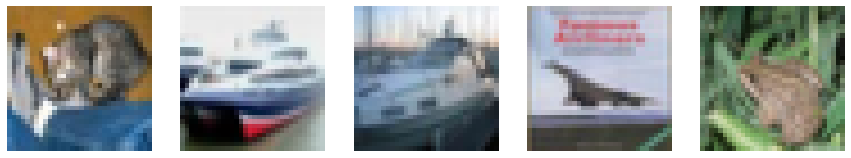

In [15]:
# first 5 original examples 
plot_images(regular_examples[0][0][:5])

Plot Adverserial Examples - observe minimal change

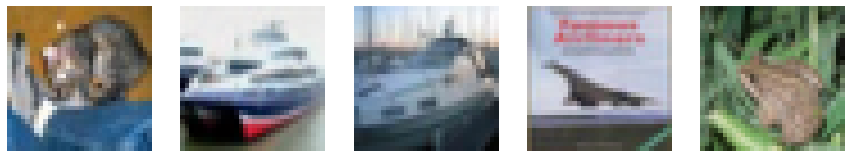

In [16]:
# first 5 original examples
plot_images(adv_examples[0][0][:5])

Compare to different optimization algorithm - variant of FGSM

In [17]:
!pip install --upgrade git+https://github.com/BorealisAI/advertorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/BorealisAI/advertorch.git to /tmp/pip-req-build-dzttimpu
  Running command git clone --filter=blob:none --quiet https://github.com/BorealisAI/advertorch.git /tmp/pip-req-build-dzttimpu
  Resolved https://github.com/BorealisAI/advertorch.git to commit e063e341c87d9a621ae1a8f72c3507d5ea5bd327
  Preparing metadata (setup.py) ... done


In [19]:
from advertorch.attacks import L2BasicIterativeAttack

batch_n = 0
batch = regular_examples[batch_n]
batch_images, batch_labels = batch


# create the L2BasicIterativeAttack instance
adversary = L2BasicIterativeAttack(model,
                                    loss_fn=torch.nn.CrossEntropyLoss(reduction="sum"),
                                    eps=0.1,
                                    nb_iter=MAX_ITERATIONS,
                                    eps_iter=0.05,
                                    clip_min=0.0,
                                    clip_max=1.0,
                                    targeted=False)

adv_examples_baseline = []
for data in testloader:
    images, labels = data
    batch_images = batch_images.to(device)
    adv_images = adversary.perturb(batch_images)

    adv_examples_baseline.append((adv_images, labels))
    break

Accuracy of baseline FGSM - better than our attack, hence ours is better

In [20]:
adv_acc = test(model, adv_examples_baseline)
adv_acc

Accuracy of the model on the test images: 70.31%


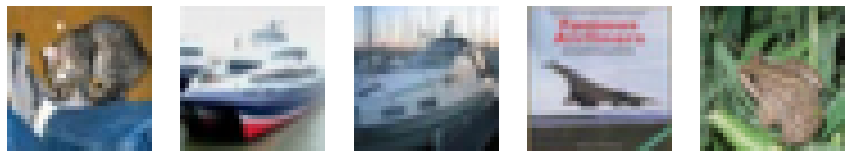

In [21]:
# first 5 original examples
plot_images(adv_examples_baseline[0][0][:5].cpu())

Measure performance in terms of L2 - more objective measure. If we let an attack run infinite time it will eventually succeed, hence our way of comparing is running the same number of iterations for both methods

In [22]:
def batch_mean_l2(original_images_batch, altered_images_batch):
    """
    Calculates the mean L2 distance between two batches of images
    
    Args:
        original_images_batch (torch.Tensor): A tensor of shape (batch_size, channels, height, width) representing a batch of images.
        altered_images_batch (torch.Tensor): A tensor of shape (batch_size, channels, height, width) representing another batch of images.
        
    Returns:
        float: The mean L2 distance between the two batches of images.
    """
    assert original_images_batch.shape == altered_images_batch.shape, "Input batches must have the same shape"
    # assume original_images_batch and altered_images_batch are two batches of images
    # with the same shape, e.g. (batch_size, channels, height, width) 
    l2_distances = torch.sqrt(torch.sum((original_images_batch - altered_images_batch)**2, dim=(1,2,3)))
    # Calculate the mean L2 distance
    mean_l2_distance = torch.mean(l2_distances).item()
    return mean_l2_distance



Lower L2 is better (however, note that models have different accuracy)

In [23]:
batch_mean_l2(regular_examples[0][0], regular_examples[0][0])

0.0

In [24]:
batch_mean_l2(regular_examples[0][0], adv_examples[0][0])


0.21387161314487457

In [25]:
batch_mean_l2(regular_examples[0][0], adv_examples_baseline[0][0].cpu())

0.10000000894069672